##Coursera - Capstone Project for IBM Data Science Certificate

#"The battle of Neighborhoods" 

Introduction / Business problem:
The mission of this project is to use Foursquare location data and regional clustering of venue information to determine what might be the most suited neighbourhood in Dubai to open a restaurant.  The objective is to have a location that is within one of the more reasonable rent zones, but also within a close enough range (5km) to a 'high' rent zone. The assumption that proximity to high rent neighborhood would result in takeout opportunities or provide residents an option to travel to our new restaurant.

The data that is used for this analysis is a combination of a CSV file (Dubai.csv and the location / venue information in Foursquare.
The file used is Dubai.csv stored on Google drive https://drive.google.com/file/d/1K0ClKa-RMr09IyxK5yptvEy8MM_tjacv/view?usp=sharing
and on GitHub repository: https://github.com/bettyweb/Coursera_Capstone/blob/master/Dubai.csv

Please note I have technical difficulties with this notebook on Watson studio and github. I therefore attach also pictures of relevant tables on the github reporsitory above as well

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

#mapping tools
!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium
import folium # map rendering library

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

     |████████████████████████████████| 92kB 743kB/s eta 0:00:01


In [11]:
import os
cwd = os.getcwd()
cwd

'/home/dsxuser/work'

In [7]:
# read csv file once loaded into working directory listed above
Geospacial_Coordinates = pd.read_csv('https://drive.google.com/file/d/1K0ClKa-RMr09IyxK5yptvEy8MM_tjacv/view?usp=sharing/Dubai.csv', sep = ',') 
# examine the shape of original input data
print(Geospacial_Coordinates.shape)

(286, 406)


#Setup Dubai Neighborhood Map

In [ ]:
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [ ]:
Geo = pd.DataFrame(Geospacial_Coordinates)
Geo.head()

!https://github.com/bettyweb/Coursera_Capstone/blob/master/1.PNG) "List first 5 rows of dataset"

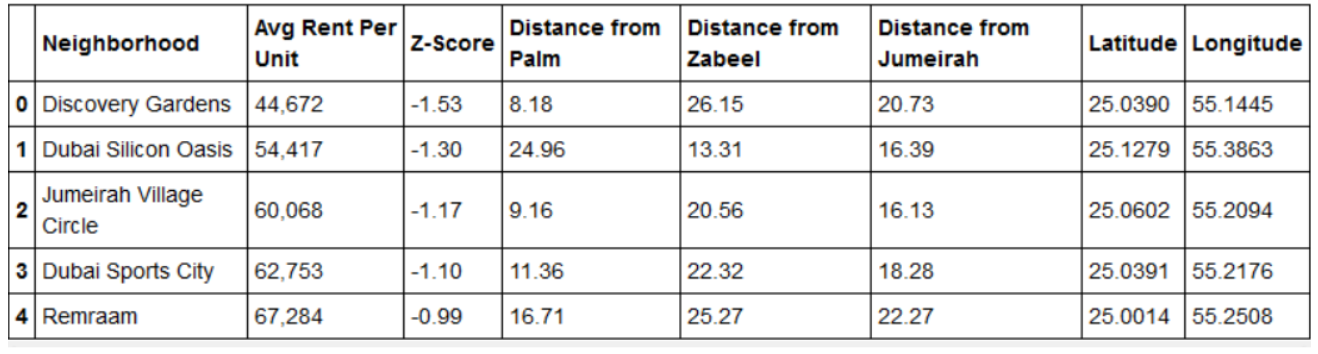

In [ ]:
Geo.dtypes

Neighborhood               object
Avg Rent Per Unit          object
Z-Score                   float64
Distance from Palm        float64
Distance from Zabeel      float64
Distance from Jumeirah    float64
Latitude                  float64
Longitude                 float64
Unnamed: 8                float64
dtype: object

In [ ]:
address = 'Dubai, UAE'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai, UAE are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai, UAE are 25.0750095, 55.1887608818332.

In [ ]:
# create map of Dubai using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(Geo['Latitude'], Geo['Longitude'], Geo['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_dubai)  
    
map_dubai

 !https://github.com/bettyweb/Coursera_Capstone/blob/master/mapdubai.PNG) "Map of Dubai neighborhoods"

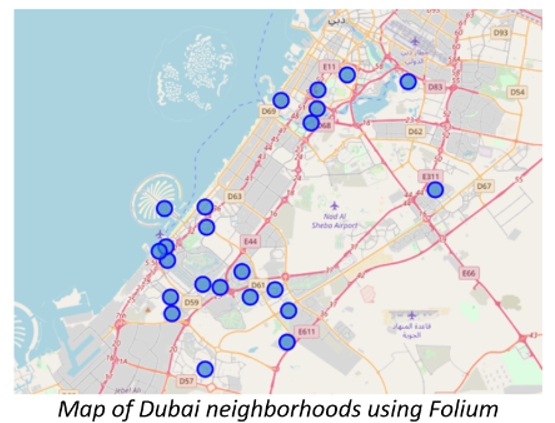

#Part - initial neighborhood comparison using Foursquare API

In [ ]:
CLIENT_ID = 'AZXSBBAMFPHQ5KE5LIPYHEP5HF0JUW0OW4OCHSXU2DEJNARO' # my Foursquare ID
CLIENT_SECRET = 'KIFRT5M2LWAT5MHJJED30RAEHDTUPHMKCVVYDTBXGRMXQ4P4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 250

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AZXSBBAMFPHQ5KE5LIPYHEP5HF0JUW0OW4OCHSXU2DEJNARO
CLIENT_SECRET:KIFRT5M2LWAT5MHJJED30RAEHDTUPHMKCVVYDTBXGRMXQ4P4

#Exploration of Dubai Marina

In [ ]:
#define objects for 'Studio District' index [15] in Geo
neighborhood_latitude = Geo.loc[15, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[15, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[15, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dubai Marina are 25.0805, 55.1403.

#get the top 100 venues that are in Dubai Marina within a radius of 500 meters.

In [ ]:
#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display GET request URL

'https://api.foursquare.com/v2/venues/explore?&client_id= AZXSBBAMFPHQ5KE5LIPYHEP5HF0JUW0OW4OCHSXU2DEJNARO &client_secret= KIFRT5M2LWAT5MHJJED30RAEHDTUPHMKCVVYDTBXGRMXQ4P4
&v=20180605&ll=25.0805,55.1403&radius=500&limit=250'

In [ ]:
results = requests.get(url).json()
results # remove ';' if you want to see json data

{'meta': {'code': 200, 'requestId': '5c1778c94c1f670180e88adb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Dubai Maryna',
  'headerFullLocation': 'Dubai Maryna, Dubai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 98,
  'suggestedBounds': {'ne': {'lat': 25.085000004500007,
    'lng': 55.145259188937594},
   'sw': {'lat': 25.075999995499995, 'lng': 55.13534081106241}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4efc823d0aafc58694fe66d6',
       'name': 'Zaatar w Zeit',
       'location': {'address': 'Marina walk',
        'lat': 25.08003611949958,
        'lng': 55.142305247548414,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08003611949958,
          'lng': 55.142305247548414}],
        'distance': 208,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Marina walk',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4efc823d0aafc58694fe66d6-0'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5606293b498e0f46d6c47f77',
       'name': 'Café Bateel',
       'location': {'address': 'Sadaf 1 , the walk, Jumeirah Beach Residance (JBR)',
        'lat': 25.08182605686763,
        'lng': 55.138065756016424,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08182605686763,
          'lng': 55.138065756016424}],
        'distance': 269,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Sadaf 1 , the walk, Jumeirah Beach Residance (JBR)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5606293b498e0f46d6c47f77-1'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf9f58bb182c9b6ffcd795a',
       'name': 'Park Island برج پارك آيلاند',
       'location': {'address': 'Dubai Marina',
        'lat': 25.082267422391965,
        'lng': 55.14212662852576,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082267422391965,
          'lng': 55.14212662852576}],
        'distance': 269,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4d954b06a243a5684965b473',
         'name': 'Residential Building (Apartment / Condo)',
         'pluralName': 'Residential Buildings (Apartments / Condos)',
         'shortName': 'Residential',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/apartment_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bf9f58bb182c9b6ffcd795a-2'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f913d8ee4b09d834fccfed2',
       'name': "Mom's Food",
       'location': {'address': 'Park Island',
        'lat': 25.082681165920015,
        'lng': 55.141600204655056,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082681165920015,
          'lng': 55.141600204655056}],
        'distance': 275,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Park Island',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4f913d8ee4b09d834fccfed2-3'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '582d60da5e56b41e7fb680af',
       'name': "MAN'OUSHE STREET (شارع منقوشة)",
       'location': {'address': 'Al Sufouh St',
        'lat': 25.082042,
        'lng': 55.140749,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082042,
          'lng': 55.140749}],
        'distance': 177,
        'cc': 'AE',
        'neighborhood': 'Jumeirah Beach Residence',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Sufouh St',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'shortName': 'Bakery',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-582d60da5e56b41e7fb680af-4'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ff1b27ae4b0db68d50b3494',
       'name': 'Club Stretch',
       'location': {'lat': 25.079336834967965,
        'lng': 55.14225300488557,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079336834967965,
          'lng': 55.14225300488557}],
        'distance': 235,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d102941735',
         'name': 'Yoga Studio',
         'pluralName': 'Yoga Studios',
         'shortName': 'Yoga Studio',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ff1b27ae4b0db68d50b3494-5'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '597214a1033693233b9924d1',
       'name': 'Blaze Burgers',
       'location': {'address': 'The Walk, JBR',
        'crossStreet': 'Next to Movenpick Hotel',
        'lat': 25.081060562735235,
        'lng': 55.137173849317655,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.081060562735235,
          'lng': 55.137173849317655}],
        'distance': 321,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Walk, JBR (Next to Movenpick Hotel)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16c941735',
         'name': 'Burger Joint',
         'pluralName': 'Burger Joints',
         'shortName': 'Burgers',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-597214a1033693233b9924d1-6'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54637709498e09ae2480cf88',
       'name': 'Jumeriah Beach Residence 1 Tram Station',
       'location': {'lat': 25.079613876544396,
        'lng': 55.13828264949973,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079613876544396,
          'lng': 55.13828264949973}],
        'distance': 226,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b51',
         'name': 'Tram Station',
         'pluralName': 'Tram Stations',
         'shortName': 'Tram',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54637709498e09ae2480cf88-7'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c2226689085d13a1cd285cc',
       'name': 'Exhale Murjan 1',
       'location': {'lat': 25.081421450115045,
        'lng': 55.14005963242027,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.081421450115045,
          'lng': 55.14005963242027}],
        'distance': 105,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d102941735',
         'name': 'Yoga Studio',
         'pluralName': 'Yoga Studios',
         'shortName': 'Yoga Studio',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4c2226689085d13a1cd285cc-8'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '56378707498ef882f85c0c27',
       'name': 'Le Bistro des Arts',
       'location': {'address': 'Dubai Marina Promenade',
        'lat': 25.07781358864863,
        'lng': 55.14035321564484,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07781358864863,
          'lng': 55.14035321564484}],
        'distance': 299,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Promenade',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '52e81612bcbc57f1066b79f1',
         'name': 'Bistro',
         'pluralName': 'Bistros',
         'shortName': 'Bistro',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-56378707498ef882f85c0c27-9'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e32bef01838be8b94cd545d',
       'name': 'The Ritz Carlton JBR - Spa',
       'location': {'address': 'Jumeirah Beach Residence',
        'lat': 25.082614864588802,
        'lng': 55.137952539047184,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082614864588802,
          'lng': 55.137952539047184}],
        'distance': 333,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumeirah Beach Residence',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1ed941735',
         'name': 'Spa',
         'pluralName': 'Spas',
         'shortName': 'Spa',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/spa_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4e32bef01838be8b94cd545d-10'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fe04b2de4b0f37d580602d3',
       'name': 'Platform 3 Fitness (P3)',
       'location': {'address': 'Park Islands',
        'crossStreet': 'Dubai Marina rd',
        'lat': 25.082351811639956,
        'lng': 55.141237413232666,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082351811639956,
          'lng': 55.141237413232666}],
        'distance': 226,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Park Islands (Dubai Marina rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d175941735',
         'name': 'Gym / Fitness Center',
         'pluralName': 'Gyms or Fitness Centers',
         'shortName': 'Gym / Fitness',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '41915562'}},
      'referralId': 'e-0-4fe04b2de4b0f37d580602d3-11'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53f51e8e11d2ae83c40a6d1c',
       'name': 'InterContinental Dubai Marina',
       'location': {'address': 'Dubai Marina',
        'lat': 25.079065020390953,
        'lng': 55.13751603772567,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079065020390953,
          'lng': 55.13751603772567}],
        'distance': 322,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-53f51e8e11d2ae83c40a6d1c-12'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b55699ef964a520b6e327e3',
       'name': 'Dubai Marina Walk (ممشى مرسى دبي)',
       'location': {'address': 'Dubai Marina',
        'lat': 25.077212974487157,
        'lng': 55.139533281326294,
        'distance': 373,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '56aa371be4b08b9a8d5734c3',
         'name': 'Waterfront',
         'pluralName': 'Waterfronts',
         'shortName': 'Waterfront',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/river_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b55699ef964a520b6e327e3-13'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0587eaf964a52092a622e3',
       'name': 'The Ritz-Carlton Dubai',
       'location': {'address': 'P.O. Box 26525',
        'lat': 25.08264496874942,
        'lng': 55.1374782210072,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08264496874942,
          'lng': 55.1374782210072}],
        'distance': 371,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['P.O. Box 26525',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b0587eaf964a52092a622e3-14'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '516e5213e4b05a9ade61bdff',
       'name': 'The Spa at The Address Dubai Marina',
       'location': {'address': 'Dubai Marina',
        'lat': 25.077540443068468,
        'lng': 55.140873383188136,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077540443068468,
          'lng': 55.140873383188136}],
        'distance': 334,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1ed941735',
         'name': 'Spa',
         'pluralName': 'Spas',
         'shortName': 'Spa',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/spa_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '69088417'}},
      'referralId': 'e-0-516e5213e4b05a9ade61bdff-15'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51094fc1e4b0ea465e46e989',
       'name': 'Cucina Mia Restaurant',
       'location': {'address': 'Opposite Royal Meridien Hotel JBR',
        'lat': 25.083686349374936,
        'lng': 55.14088913913356,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083686349374936,
          'lng': 55.14088913913356}],
        'distance': 359,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Opposite Royal Meridien Hotel JBR',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '60742094'}},
      'referralId': 'e-0-51094fc1e4b0ea465e46e989-16'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf0f6fe3a15d13ada153f9f',
       'name': 'Starbucks (ستاربكس)',
       'location': {'address': 'Jumeirah Beach Residence',
        'crossStreet': 'Opposite to the Ritz Carlton Hotel',
        'lat': 25.081102350357092,
        'lng': 55.13724450292884,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.081102350357092,
          'lng': 55.13724450292884}],
        'distance': 315,
        'postalCode': 'AE',
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumeirah Beach Residence (Opposite to the Ritz Carlton Hotel)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bf0f6fe3a15d13ada153f9f-17'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0aaf4af964a5205d2623e3',
       'name': 'Address Dubai Marina',
       'location': {'address': 'Dubai Marina',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.077045147754163,
        'lng': 55.14046920137228,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077045147754163,
          'lng': 55.14046920137228}],
        'distance': 384,
        'postalCode': '32923',
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina (Sheikh Zayed Rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '69088416'}},
      'referralId': 'e-0-4b0aaf4af964a5205d2623e3-18'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '540beaba498e187680d9e0b6',
       'name': 'City Premiere Marina Deluxe Hotel Apartments',
       'location': {'lat': 25.07950867658917,
        'lng': 55.1434385898882,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07950867658917,
          'lng': 55.1434385898882}],
        'distance': 335,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-540beaba498e187680d9e0b6-19'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0587eaf964a5209fa622e3',
       'name': 'Le Royal Méridien Beach Resort & Spa',
       'location': {'address': 'Al Sufouh Rd',
        'lat': 25.08428,
        'lng': 55.14044,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08428,
          'lng': 55.14044}],
        'distance': 421,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina, Dubai',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Sufouh Rd',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d12f951735',
         'name': 'Resort',
         'pluralName': 'Resorts',
         'shortName': 'Resort',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/resort_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b0587eaf964a5209fa622e3-20'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f3ba55ee4b08b7acee3829f',
       'name': 'Shades',
       'location': {'address': 'The Address Dubai Marina',
        'crossStreet': 'Emaar St.',
        'lat': 25.077006654848084,
        'lng': 55.13993184808978,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077006654848084,
          'lng': 55.13993184808978}],
        'distance': 390,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Address Dubai Marina (Emaar St.)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d121941735',
         'name': 'Lounge',
         'pluralName': 'Lounges',
         'shortName': 'Lounge',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '52098819'}},
      'referralId': 'e-0-4f3ba55ee4b08b7acee3829f-21'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55e1e408498e95ee464be025',
       'name': 'Marina Social',
       'location': {'address': 'Level 1, InterContinental Dubai Marina',
        'crossStreet': 'Bay Central',
        'lat': 25.07877191909143,
        'lng': 55.13852679180269,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07877191909143,
          'lng': 55.13852679180269}],
        'distance': 262,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina, Dubai',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Level 1, InterContinental Dubai Marina (Bay Central)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '52e81612bcbc57f1066b79f9',
         'name': 'Modern European Restaurant',
         'pluralName': 'Modern European Restaurants',
         'shortName': 'Modern European',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-55e1e408498e95ee464be025-22'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c497fcc9f2ad13abb5b5d53',
       'name': 'Mazina Restaurant',
       'location': {'address': 'The Address Dubai Marina',
        'lat': 25.077563240524423,
        'lng': 55.14081838550624,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077563240524423,
          'lng': 55.14081838550624}],
        'distance': 331,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Address Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d142941735',
         'name': 'Asian Restaurant',
         'pluralName': 'Asian Restaurants',
         'shortName': 'Asian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '69087776'}},
      'referralId': 'e-0-4c497fcc9f2ad13abb5b5d53-23'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51813f4c498e034fb47e9d31',
       'name': 'Al Shorfa Resturant & Cafe (الشرفة مطعم و مقهى)',
       'location': {'address': 'JBR',
        'crossStreet': 'JBR',
        'lat': 25.083372577625596,
        'lng': 55.1405994199436,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083372577625596,
          'lng': 55.1405994199436}],
        'distance': 321,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR (JBR)', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1c0941735',
         'name': 'Mediterranean Restaurant',
         'pluralName': 'Mediterranean Restaurants',
         'shortName': 'Mediterranean',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51813f4c498e034fb47e9d31-24'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '591190318c35dc6357a02c22',
       'name': 'Rixos Premium Dubai',
       'location': {'address': 'Jumeirah Beach Residence - The Walk',
        'lat': 25.079877753485057,
        'lng': 55.13610769206774,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079877753485057,
          'lng': 55.13610769206774}],
        'distance': 428,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumeirah Beach Residence - The Walk',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-591190318c35dc6357a02c22-25'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d7b222273ca5481c37c467c',
       'name': 'JA Oasis Beach Tower #JAOasisBeachTower',
       'location': {'address': 'Al Fattan Tower',
        'crossStreet': 'The Walk, Jumeirah Beach Residence',
        'lat': 25.07977672110495,
        'lng': 55.13605590751577,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07977672110495,
          'lng': 55.13605590751577}],
        'distance': 435,
        'postalCode': '9255',
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Fattan Tower (The Walk, Jumeirah Beach Residence)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4d7b222273ca5481c37c467c-26'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fdd3fbce4b01d23396afac7',
       'name': 'Address Marina Hotel Fitness Center',
       'location': {'address': 'Dubai Marina',
        'lat': 25.077042984943898,
        'lng': 55.14100793422769,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077042984943898,
          'lng': 55.14100793422769}],
        'distance': 391,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d176941735',
         'name': 'Gym',
         'pluralName': 'Gyms',
         'shortName': 'Gym',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '69088412'}},
      'referralId': 'e-0-4fdd3fbce4b01d23396afac7-27'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52c1476e11d22fac8f7c445c',
       'name': 'Lobby Lounge',
       'location': {'lat': 25.08267889016693,
        'lng': 55.137313099657476,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08267889016693,
          'lng': 55.137313099657476}],
        'distance': 386,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1dc931735',
         'name': 'Tea Room',
         'pluralName': 'Tea Rooms',
         'shortName': 'Tea Room',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tearoom_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-52c1476e11d22fac8f7c445c-28'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0ae8a0f964a520dc2923e3',
       'name': 'Reel Cinemas (ريل سينما)',
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.07656956721927,
        'lng': 55.1400156508692,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07656956721927,
          'lng': 55.1400156508692}],
        'distance': 438,
        'postalCode': '2748',
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Sheikh Zayed Rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d180941735',
         'name': 'Multiplex',
         'pluralName': 'Multiplexes',
         'shortName': 'Cineplex',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b0ae8a0f964a520dc2923e3-29'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c05ee2dd3842d7f68f1be41',
       'name': 'Mövenpick Hotel Jumeirah Beach',
       'location': {'address': 'The Walk',
        'crossStreet': 'Jumeirah Beach Residence',
        'lat': 25.080234945937505,
        'lng': 55.13636896603717,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.080234945937505,
          'lng': 55.13636896603717}],
        'distance': 397,
        'postalCode': '282825',
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Walk (Jumeirah Beach Residence)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4c05ee2dd3842d7f68f1be41-30'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b9e5c7ff964a520eddc36e3',
       'name': 'Radisson Blu Residence',
       'location': {'address': 'Plot No. 392-260 Street K Dubai Marina',
        'crossStreet': 'Plot 392-260',
        'lat': 25.078488010930137,
        'lng': 55.14314750429912,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.078488010930137,
          'lng': 55.14314750429912}],
        'distance': 364,
        'cc': 'AE',
        'city': 'Dubai',
        'state': 'Emirate',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Plot No. 392-260 Street K Dubai Marina (Plot 392-260)',
         'Dubai',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b9e5c7ff964a520eddc36e3-31'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cbf2355acd48cfa54c2413f',
       'name': 'Suvoroff',
       'location': {'address': 'Jumeira Beach Residence',
        'lat': 25.080781747734836,
        'lng': 55.1396573631064,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.080781747734836,
          'lng': 55.1396573631064}],
        'distance': 71,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumeira Beach Residence',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d109941735',
         'name': 'Eastern European Restaurant',
         'pluralName': 'Eastern European Restaurants',
         'shortName': 'Eastern European',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4cbf2355acd48cfa54c2413f-32'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227f90d11d22fb8ba38b8d5',
       'name': 'JBR Walk Running Field',
       'location': {'address': 'JBR Walk',
        'lat': 25.081112810176112,
        'lng': 55.13726835798631,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.081112810176112,
          'lng': 55.13726835798631}],
        'distance': 313,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR Walk', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d159941735',
         'name': 'Trail',
         'pluralName': 'Trails',
         'shortName': 'Trail',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5227f90d11d22fb8ba38b8d5-33'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51978473498e459555323a3d',
       'name': 'Pier 7',
       'location': {'address': 'Dubai Marina',
        'lat': 25.076533663693144,
        'lng': 55.138728546916,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076533663693144,
          'lng': 55.138728546916}],
        'distance': 469,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51978473498e459555323a3d-34'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0ad94cf964a520da2823e3',
       'name': 'Dubai Marina Mall (دبي مارينا مول)',
       'location': {'address': 'Dubai Marina',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.07638772324717,
        'lng': 55.13977940216581,
        'distance': 460,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina (Sheikh Zayed Rd)',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fd941735',
         'name': 'Shopping Mall',
         'pluralName': 'Shopping Malls',
         'shortName': 'Mall',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b0ad94cf964a520da2823e3-35'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '584edfe723188e0c097740fb',
       'name': 'Zaroob Restaurant',
       'location': {'address': 'Al Marsa',
        'lat': 25.077894789190783,
        'lng': 55.1432383562656,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077894789190783,
          'lng': 55.1432383562656}],
        'distance': 414,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Marsa', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-584edfe723188e0c097740fb-36'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb1c031f964a5207ea13ce3',
       'name': 'La Sirene Hair Beauty & Spa',
       'location': {'address': 'Al Fattan Marine Tower',
        'crossStreet': 'Jumeira Beach Residence',
        'lat': 25.07978080347724,
        'lng': 55.13619342897744,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07978080347724,
          'lng': 55.13619342897744}],
        'distance': 421,
        'cc': 'AE',
        'neighborhood': 'JBR',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Fattan Marine Tower (Jumeira Beach Residence)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110951735',
         'name': 'Salon / Barbershop',
         'pluralName': 'Salons / Barbershops',
         'shortName': 'Salon / Barbershop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/salon_barber_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bb1c031f964a5207ea13ce3-37'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54cbc439498ec48ec87d636b',
       'name': 'SALT (سولت)',
       'location': {'lat': 25.0770094086005,
        'lng': 55.13899260676013,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.0770094086005,
          'lng': 55.13899260676013}],
        'distance': 410,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1cb941735',
         'name': 'Food Truck',
         'pluralName': 'Food Trucks',
         'shortName': 'Food Truck',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54cbc439498ec48ec87d636b-38'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57c2180b498e83e89bf5c1d4',
       'name': 'Jouri Gourmet (جوري غورميه)',
       'location': {'lat': 25.079745744492055,
        'lng': 55.14212257428586,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079745744492055,
          'lng': 55.14212257428586}],
        'distance': 202,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d119941735',
         'name': 'Hookah Bar',
         'pluralName': 'Hookah Bars',
         'shortName': 'Hookah Bar',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/hookahbar_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-57c2180b498e83e89bf5c1d4-39'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50ee6dc8e4b03045ab2b8e14',
       'name': 'The Ritz-Carlton Beachfront',
       'location': {'address': 'Jumeirah Beach Resort',
        'lat': 25.083492978518727,
        'lng': 55.136837040113306,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083492978518727,
          'lng': 55.136837040113306}],
        'distance': 482,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumeirah Beach Resort',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e2941735',
         'name': 'Beach',
         'pluralName': 'Beaches',
         'shortName': 'Beach',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-50ee6dc8e4b03045ab2b8e14-40'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8caf458b81f047f13cab6c',
       'name': 'The Library Bar @ Ritz Carlton',
       'location': {'address': 'JBR',
        'lat': 25.082607788945417,
        'lng': 55.137347215430516,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082607788945417,
          'lng': 55.137347215430516}],
        'distance': 379,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d121941735',
         'name': 'Lounge',
         'pluralName': 'Lounges',
         'shortName': 'Lounge',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4e8caf458b81f047f13cab6c-41'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ee71a5793adf8e1aa156903',
       'name': 'Shakespeare and Co.',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.076522718650672,
        'lng': 55.139074080294336,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076522718650672,
          'lng': 55.139074080294336}],
        'distance': 459,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'shortName': 'Café',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ee71a5793adf8e1aa156903-42'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '513d907ce4b04f7032bec60b',
       'name': 'Ritz Carlton PoolArea',
       'location': {'lat': 25.083771402104407,
        'lng': 55.137925475787114,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083771402104407,
          'lng': 55.137925475787114}],
        'distance': 435,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d15e941735',
         'name': 'Pool',
         'pluralName': 'Pools',
         'shortName': 'Pool',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/pool_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-513d907ce4b04f7032bec60b-43'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52cda52e498eb9f880b5c496',
       'name': 'Atelier M',
       'location': {'address': 'Pier 7',
        'crossStreet': 'Marina St',
        'lat': 25.076414816445165,
        'lng': 55.13890786745345,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076414816445165,
          'lng': 55.13890786745345}],
        'distance': 475,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Pier 7 (Marina St)',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d121941735',
         'name': 'Lounge',
         'pluralName': 'Lounges',
         'shortName': 'Lounge',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-52cda52e498eb9f880b5c496-44'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5044d2b6e4b09ae79cfde32d',
       'name': 'Xiao Wei Yang Hot Pot',
       'location': {'address': 'The Walk, Jumeirah Beach Residence',
        'lat': 25.084688,
        'lng': 55.14199,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.084688,
          'lng': 55.14199}],
        'distance': 496,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Walk, Jumeirah Beach Residence',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d145941735',
         'name': 'Chinese Restaurant',
         'pluralName': 'Chinese Restaurants',
         'shortName': 'Chinese',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5044d2b6e4b09ae79cfde32d-45'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b2e029cf964a52060dc24e3',
       'name': 'wagamama',
       'location': {'address': 'JBR',
        'lat': 25.079818811593903,
        'lng': 55.13653437197266,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079818811593903,
          'lng': 55.13653437197266}],
        'distance': 387,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR', 'دبي مارينا', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d142941735',
         'name': 'Asian Restaurant',
         'pluralName': 'Asian Restaurants',
         'shortName': 'Asian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b2e029cf964a52060dc24e3-46'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '587f2de46cea3f620420c1b1',
       'name': 'Nezesaussi Grill',
       'location': {'lat': 25.07705992363335,
        'lng': 55.14113321900368,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07705992363335,
          'lng': 55.14113321900368}],
        'distance': 392,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي مارينا', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d11d941735',
         'name': 'Sports Bar',
         'pluralName': 'Sports Bars',
         'shortName': 'Sports Bar',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/sportsbar_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-587f2de46cea3f620420c1b1-47'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '597dcf9f0e5da85edec38a7d',
       'name': 'SALT',
       'location': {'lat': 25.076753664836613,
        'lng': 55.13904923078617,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076753664836613,
          'lng': 55.13904923078617}],
        'distance': 435,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16c941735',
         'name': 'Burger Joint',
         'pluralName': 'Burger Joints',
         'shortName': 'Burgers',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-597dcf9f0e5da85edec38a7d-48'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd2ede141b9ef3b65e2fee5',
       'name': 'Starbucks (ستاربكس)',
       'location': {'address': 'Sheikh Zayed Rd',
        'lat': 25.07613974216738,
        'lng': 55.14111154974231,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07613974216738,
          'lng': 55.14111154974231}],
        'distance': 492,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Sheikh Zayed Rd',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bd2ede141b9ef3b65e2fee5-49'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5217cc2711d27bb55a037438',
       'name': 'The Address Hotel Residences',
       'location': {'lat': 25.07702234413739,
        'lng': 55.14003268716347,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07702234413739,
          'lng': 55.14003268716347}],
        'distance': 388,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'shortName': 'Hotel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5217cc2711d27bb55a037438-50'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51494fa3e4b0631e06a3fb64',
       'name': 'IHOP (آي هوب)',
       'location': {'address': 'JBR-Unit GM11 Tower JBR 03',
        'lat': 25.07914615978791,
        'lng': 55.135715961587266,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07914615978791,
          'lng': 55.135715961587266}],
        'distance': 486,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR-Unit GM11 Tower JBR 03',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d143941735',
         'name': 'Breakfast Spot',
         'pluralName': 'Breakfast Spots',
         'shortName': 'Breakfast',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/breakfast_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51494fa3e4b0631e06a3fb64-51'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '525789ea11d21486eaceca45',
       'name': 'Wingsters وينجستر',
       'location': {'address': 'Marina Diamond 1 Tower, Dubai Marina',
        'crossStreet': 'Street behind the Radisson Blu Residences',
        'lat': 25.08039119160803,
        'lng': 55.14464898703715,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08039119160803,
          'lng': 55.14464898703715}],
        'distance': 438,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Marina Diamond 1 Tower, Dubai Marina (Street behind the Radisson Blu Residences)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d14e941735',
         'name': 'American Restaurant',
         'pluralName': 'American Restaurants',
         'shortName': 'American',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '68900508'}},
      'referralId': 'e-0-525789ea11d21486eaceca45-52'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb099d1f964a520ae4e3ce3',
       'name': 'The Talk Restaurant',
       'location': {'address': 'Mövenpick Hotel Jumeirah Beach',
        'crossStreet': 'JBR Walk',
        'lat': 25.080340936562838,
        'lng': 55.136640125191725,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.080340936562838,
          'lng': 55.136640125191725}],
        'distance': 369,
        'postalCode': '282825',
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Mövenpick Hotel Jumeirah Beach (JBR Walk)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bb099d1f964a520ae4e3ce3-53'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535d35fc498ebcf55348c00d',
       'name': 'Cargo',
       'location': {'address': 'Pier 7',
        'crossStreet': 'Dubai Marina',
        'lat': 25.076834912064143,
        'lng': 55.13871846823104,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076834912064143,
          'lng': 55.13871846823104}],
        'distance': 438,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Pier 7 (Dubai Marina)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d11e941735',
         'name': 'Cocktail Bar',
         'pluralName': 'Cocktail Bars',
         'shortName': 'Cocktail',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-535d35fc498ebcf55348c00d-54'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '542081db498e1ced3bb27265',
       'name': 'Asia Asia',
       'location': {'address': 'Pier 7',
        'lat': 25.076587712859634,
        'lng': 55.138777047642364,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076587712859634,
          'lng': 55.138777047642364}],
        'distance': 461,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Pier 7', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d111941735',
         'name': 'Japanese Restaurant',
         'pluralName': 'Japanese Restaurants',
         'shortName': 'Japanese',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-542081db498e1ced3bb27265-55'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50efb04ee4b0ce20266463a7',
       'name': 'Simsim (سمسم)',
       'location': {'address': 'JBR',
        'lat': 25.08070764332202,
        'lng': 55.136839291558665,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08070764332202,
          'lng': 55.136839291558665}],
        'distance': 349,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-50efb04ee4b0ce20266463a7-56'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4efe1803722e0f07705ab46e',
       'name': 'Starbucks',
       'location': {'address': 'دبي',
        'crossStreet': 'جي بي ار',
        'lat': 25.08118242148295,
        'lng': 55.13727353795743,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08118242148295,
          'lng': 55.13727353795743}],
        'distance': 314,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي (جي بي ار)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4efe1803722e0f07705ab46e-57'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '569887db498e61bda9853dc9',
       'name': '136.1 Yoga Studio',
       'location': {'lat': 25.081609371927872,
        'lng': 55.14497979327985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.081609371927872,
          'lng': 55.14497979327985}],
        'distance': 487,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d102941735',
         'name': 'Yoga Studio',
         'pluralName': 'Yoga Studios',
         'shortName': 'Yoga Studio',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-569887db498e61bda9853dc9-58'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53f771da498e78515eadb0f8',
       'name': 'Uchkuduk - Uzbek Cuisine',
       'location': {'address': 'Trident Grand Residence',
        'crossStreet': 'Across From Habtoor Grand Hotel',
        'lat': 25.083976249462456,
        'lng': 55.1410717414167,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083976249462456,
          'lng': 55.1410717414167}],
        'distance': 394,
        'postalCode': '9244',
        'cc': 'AE',
        'neighborhood': 'JBR',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Trident Grand Residence (Across From Habtoor Grand Hotel)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '5293a7563cf9994f4e043a44',
         'name': 'Russian Restaurant',
         'pluralName': 'Russian Restaurants',
         'shortName': 'Russian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/russian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '94732145'}},
      'referralId': 'e-0-53f771da498e78515eadb0f8-59'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51aa2aec498e0f1331d0fb90',
       'name': 'Blue Jade',
       'location': {'address': 'The Walk at JBR',
        'lat': 25.082759185963678,
        'lng': 55.13757288191048,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082759185963678,
          'lng': 55.13757288191048}],
        'distance': 372,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Walk at JBR',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d142941735',
         'name': 'Asian Restaurant',
         'pluralName': 'Asian Restaurants',
         'shortName': 'Asian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51aa2aec498e0f1331d0fb90-60'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52dccb89498ec95c36002d70',
       'name': "Massimo's",
       'location': {'address': 'Park Island Dubai Marina',
        'lat': 25.08238107046071,
        'lng': 55.14274807646712,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08238107046071,
          'lng': 55.14274807646712}],
        'distance': 323,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Park Island Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '76756936'}},
      'referralId': 'e-0-52dccb89498ec95c36002d70-61'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5982643b16ef675760114589',
       'name': 'Black Tap Craft Burgers & Shakes',
       'location': {'crossStreet': 'Salman Bin Abdulaziz',
        'lat': 25.079816016099613,
        'lng': 55.136243525560914,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079816016099613,
          'lng': 55.136243525560914}],
        'distance': 416,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Salman Bin Abdulaziz',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16c941735',
         'name': 'Burger Joint',
         'pluralName': 'Burger Joints',
         'shortName': 'Burgers',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5982643b16ef675760114589-62'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4df76f981838c789e8b969a1',
       'name': 'Caracalla Spa & Health Club @ Le Royal Meridien',
       'location': {'lat': 25.0842029257964,
        'lng': 55.13989257196537,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.0842029257964,
          'lng': 55.13989257196537}],
        'distance': 414,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d175941735',
         'name': 'Gym / Fitness Center',
         'pluralName': 'Gyms or Fitness Centers',
         'shortName': 'Gym / Fitness',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4df76f981838c789e8b969a1-63'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b9e5fccf964a52000de36e3',
       'name': 'Brasserie',
       'location': {'address': 'Royal Meridien',
        'lat': 25.084758451256718,
        'lng': 55.13981064578634,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.084758451256718,
          'lng': 55.13981064578634}],
        'distance': 476,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Royal Meridien',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d10c941735',
         'name': 'French Restaurant',
         'pluralName': 'French Restaurants',
         'shortName': 'French',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b9e5fccf964a52000de36e3-64'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b74c23df964a5207af02de3',
       'name': 'Al Fattan Marine Towers',
       'location': {'address': 'JBR',
        'lat': 25.07975336316278,
        'lng': 55.13614366489748,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07975336316278,
          'lng': 55.13614366489748}],
        'distance': 427,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1fd941735',
         'name': 'Shopping Mall',
         'pluralName': 'Shopping Malls',
         'shortName': 'Mall',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b74c23df964a5207af02de3-65'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '511a5152e4b0030c61c31b77',
       'name': 'La Baie Lounge',
       'location': {'address': 'The Ritz Carlton Dubai',
        'crossStreet': 'P.O. Box 26525',
        'lat': 25.08351654792218,
        'lng': 55.13725500262663,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08351654792218,
          'lng': 55.13725500262663}],
        'distance': 454,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Ritz Carlton Dubai (P.O. Box 26525)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d144941735',
         'name': 'Caribbean Restaurant',
         'pluralName': 'Caribbean Restaurants',
         'shortName': 'Caribbean',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-511a5152e4b0030c61c31b77-66'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cb5dc9664998cfaae0711a2',
       'name': 'Rhodes Twenty10',
       'location': {'address': 'Le Royal Meridien Beach Resort & Spa',
        'crossStreet': 'Al Sufouh Road',
        'lat': 25.084830735996913,
        'lng': 55.139704784881005,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.084830735996913,
          'lng': 55.139704784881005}],
        'distance': 485,
        'postalCode': '24970',
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Le Royal Meridien Beach Resort & Spa (Al Sufouh Road)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1cc941735',
         'name': 'Steakhouse',
         'pluralName': 'Steakhouses',
         'shortName': 'Steakhouse',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/steakhouse_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '90259360'}},
      'referralId': 'e-0-4cb5dc9664998cfaae0711a2-67'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4efecca09a520dfd656668a9',
       'name': 'Club Lounge',
       'location': {'address': 'Ritz Carlton Dubai',
        'crossStreet': 'JBR',
        'lat': 25.08324111591411,
        'lng': 55.13762550374704,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08324111591411,
          'lng': 55.13762550374704}],
        'distance': 407,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Ritz Carlton Dubai (JBR)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d121941735',
         'name': 'Lounge',
         'pluralName': 'Lounges',
         'shortName': 'Lounge',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4efecca09a520dfd656668a9-68'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51d2a176498e072a57f83221',
       'name': 'Sephora',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.076760930524483,
        'lng': 55.139278897111886,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076760930524483,
          'lng': 55.139278897111886}],
        'distance': 428,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d10c951735',
         'name': 'Cosmetics Shop',
         'pluralName': 'Cosmetics Shops',
         'shortName': 'Cosmetics',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/beauty_cosmetic_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51d2a176498e072a57f83221-69'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55f7ef86498ef0f83de007e6',
       'name': 'Five Guys',
       'location': {'address': 'The Exchange 5 Market St.',
        'lat': 25.077067370642464,
        'lng': 55.13943753037929,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077067370642464,
          'lng': 55.13943753037929}],
        'distance': 391,
        'postalCode': 'BD1 1EG',
        'cc': 'AE',
        'city': 'Bradford',
        'state': 'West Yorkshire',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Exchange 5 Market St.',
         'Bradford',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16c941735',
         'name': 'Burger Joint',
         'pluralName': 'Burger Joints',
         'shortName': 'Burgers',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-55f7ef86498ef0f83de007e6-70'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50f56773e4b04c8b3f4c3deb',
       'name': 'Sarouja',
       'location': {'address': 'Al Sufouh Rd, before JBR Rd',
        'crossStreet': 'شارع الصفوح قبل مدخل الممشى',
        'lat': 25.083911445807587,
        'lng': 55.143159056460846,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.083911445807587,
          'lng': 55.143159056460846}],
        'distance': 476,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Sufouh Rd, before JBR Rd (شارع الصفوح قبل مدخل الممشى)',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '83161979'}},
      'referralId': 'e-0-50f56773e4b04c8b3f4c3deb-71'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b485a67f964a5200c4c26e3',
       'name': 'Le Pain Quotidien',
       'location': {'address': 'Jumairah Beach Residence, Rimal Building, The Walk',
        'crossStreet': 'Jumeirah Beach Residence',
        'lat': 25.077059,
        'lng': 55.140205,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077059,
          'lng': 55.140205}],
        'distance': 383,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Jumairah Beach Residence, Rimal Building, The Walk (Jumeirah Beach Residence)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d10c941735',
         'name': 'French Restaurant',
         'pluralName': 'French Restaurants',
         'shortName': 'French',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b485a67f964a5200c4c26e3-72'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c4c6a479c8d2d7f5479646c',
       'name': 'Kambaa',
       'location': {'address': 'The Address Dubai Marina',
        'lat': 25.07679281677242,
        'lng': 55.141201004166746,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07679281677242,
          'lng': 55.141201004166746}],
        'distance': 422,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Address Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '69088414'}},
      'referralId': 'e-0-4c4c6a479c8d2d7f5479646c-73'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51829db3498ef68cdf0e46bf',
       'name': 'Abd El Wahab (عبد الوهاب)',
       'location': {'address': 'Pier 7',
        'lat': 25.076847904842317,
        'lng': 55.13877165867141,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076847904842317,
          'lng': 55.13877165867141}],
        'distance': 434,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Pier 7', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '58daa1558bbb0b01f18ec1cd',
         'name': 'Lebanese Restaurant',
         'pluralName': 'Lebanese Restaurants',
         'shortName': 'Lebanese',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-51829db3498ef68cdf0e46bf-74'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bcc4c7d937ca593a8cfaa92',
       'name': "McDonald's (ماكدونالدز)",
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.076540434701247,
        'lng': 55.139264863214315,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076540434701247,
          'lng': 55.139264863214315}],
        'distance': 452,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Sheikh Zayed Rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d16e941735',
         'name': 'Fast Food Restaurant',
         'pluralName': 'Fast Food Restaurants',
         'shortName': 'Fast Food',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bcc4c7d937ca593a8cfaa92-75'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b9e60d8f964a5204dde36e3',
       'name': 'Waitrose',
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.077098716241615,
        'lng': 55.13918474505592,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077098716241615,
          'lng': 55.13918474505592}],
        'distance': 394,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Sheikh Zayed Rd)',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
         'name': 'Supermarket',
         'pluralName': 'Supermarkets',
         'shortName': 'Supermarket',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b9e60d8f964a5204dde36e3-76'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53f87ccb498e9554d54ef030',
       'name': 'The Scene by Simon Rimmer',
       'location': {'address': 'Pier7 - 4th Floor',
        'lat': 25.07677751810005,
        'lng': 55.13864413810276,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07677751810005,
          'lng': 55.13864413810276}],
        'distance': 446,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina, Dubai',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Pier7 - 4th Floor',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '52e81612bcbc57f1066b7a05',
         'name': 'English Restaurant',
         'pluralName': 'English Restaurants',
         'shortName': 'English',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '97187455'}},
      'referralId': 'e-0-53f87ccb498e9554d54ef030-77'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5036691fe4b053240d1481a5',
       'name': 'Speakeasy Bar & Restaurant',
       'location': {'address': 'Lower Plaza (LP) Level, Ramada Plaza Jumeirah Beach',
        'crossStreet': 'Bahar 7',
        'lat': 25.078157696889715,
        'lng': 55.13621159806166,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.078157696889715,
          'lng': 55.13621159806166}],
        'distance': 487,
        'postalCode': '118555',
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Lower Plaza (LP) Level, Ramada Plaza Jumeirah Beach (Bahar 7)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1d4941735',
         'name': 'Speakeasy',
         'pluralName': 'Speakeasies',
         'shortName': 'Speakeasy',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/secretbar_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5036691fe4b053240d1481a5-78'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50731ab2e4b0e1b65f67f0df',
       'name': 'Amaseena',
       'location': {'address': 'JBR Road',
        'lat': 25.082362,
        'lng': 55.136658,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082362,
          'lng': 55.136658}],
        'distance': 421,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['JBR Road', 'دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d115941735',
         'name': 'Middle Eastern Restaurant',
         'pluralName': 'Middle Eastern Restaurants',
         'shortName': 'Middle Eastern',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-50731ab2e4b0e1b65f67f0df-79'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5224302611d2ebf3dbc7463d',
       'name': 'Infinity Pool / Shades',
       'location': {'lat': 25.0770232900724,
        'lng': 55.1401969471159,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.0770232900724,
          'lng': 55.1401969471159}],
        'distance': 387,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d15e941735',
         'name': 'Pool',
         'pluralName': 'Pools',
         'shortName': 'Pool',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/pool_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5224302611d2ebf3dbc7463d-80'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ce7d39dfe90a35d86ad3e0e',
       'name': 'Favorite Things',
       'location': {'address': 'Marina Mall',
        'lat': 25.076681348317113,
        'lng': 55.13969856668666,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076681348317113,
          'lng': 55.13969856668666}],
        'distance': 429,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Marina Mall', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d118951735',
         'name': 'Grocery Store',
         'pluralName': 'Grocery Stores',
         'shortName': 'Grocery Store',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ce7d39dfe90a35d86ad3e0e-81'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59dbbd3f51950e4b1aaa74bd',
       'name': 'Inner City Zoo',
       'location': {'address': 'Rixos Premium Hotel',
        'crossStreet': 'JBR',
        'lat': 25.080344861963752,
        'lng': 55.13562478239317,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.080344861963752,
          'lng': 55.13562478239317}],
        'distance': 471,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Rixos Premium Hotel (JBR)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d11f941735',
         'name': 'Nightclub',
         'pluralName': 'Nightclubs',
         'shortName': 'Nightclub',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/nightclub_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-59dbbd3f51950e4b1aaa74bd-82'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b72cfa3f964a520d1892de3',
       'name': 'Café Nero (كافيه نيرو)',
       'location': {'address': 'Al Marsa St',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.076150158587446,
        'lng': 55.14109737813229,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076150158587446,
          'lng': 55.14109737813229}],
        'distance': 490,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Marsa St (Sheikh Zayed Rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b72cfa3f964a520d1892de3-83'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5152ee13e4b0563568bcc79f',
       'name': 'Costa Coffee',
       'location': {'address': 'Dubai Marina Mall Promenade',
        'lat': 25.07701883839699,
        'lng': 55.13987640484194,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07701883839699,
          'lng': 55.13987640484194}],
        'distance': 389,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall Promenade',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5152ee13e4b0563568bcc79f-84'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf6546e9abec9b66b9a25e8',
       'name': 'Ted baker',
       'location': {'address': 'Dubai marina mall',
        'lat': 25.076101499790184,
        'lng': 55.14125169919437,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076101499790184,
          'lng': 55.14125169919437}],
        'distance': 498,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai marina mall',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d103951735',
         'name': 'Clothing Store',
         'pluralName': 'Clothing Stores',
         'shortName': 'Apparel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bf6546e9abec9b66b9a25e8-85'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '510d51d8e4b0faae32ccdd13',
       'name': 'Conti Confetteria Milano',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.07622108490372,
        'lng': 55.14141229525668,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07622108490372,
          'lng': 55.14141229525668}],
        'distance': 489,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'shortName': 'Coffee Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-510d51d8e4b0faae32ccdd13-86'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4edcc6429a5286d92221099a',
       'name': 'H&M',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.07643,
        'lng': 55.140504,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07643,
          'lng': 55.140504}],
        'distance': 453,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d103951735',
         'name': 'Clothing Store',
         'pluralName': 'Clothing Stores',
         'shortName': 'Apparel',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4edcc6429a5286d92221099a-87'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc73f9d6501c9b6ae053e29',
       'name': "Carluccio's (كارليوكوس)",
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Marina St',
        'lat': 25.077000219883292,
        'lng': 55.13905151887153,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.077000219883292,
          'lng': 55.13905151887153}],
        'distance': 409,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Marina St)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4bc73f9d6501c9b6ae053e29-88'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ca3789cd7c337043c43a162',
       'name': 'Splendido',
       'location': {'address': 'The Ritz Carlton Dubai',
        'crossStreet': 'JBR',
        'lat': 25.08302937610757,
        'lng': 55.13745597135421,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08302937610757,
          'lng': 55.13745597135421}],
        'distance': 401,
        'cc': 'AE',
        'city': 'دبي مارينا',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['The Ritz Carlton Dubai (JBR)',
         'دبي مارينا',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4ca3789cd7c337043c43a162-89'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4befc1fed4e4d13a598d15a7',
       'name': 'Baskin Robbins',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.076562452090478,
        'lng': 55.13937118381883,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076562452090478,
          'lng': 55.13937118381883}],
        'distance': 448,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1c9941735',
         'name': 'Ice Cream Shop',
         'pluralName': 'Ice Cream Shops',
         'shortName': 'Ice Cream',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4befc1fed4e4d13a598d15a7-90'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f74ceb50039782e9c33d1c2',
       'name': 'Monte Carlo Stars Dubai Marina',
       'location': {'address': 'Al Sufouh Road',
        'crossStreet': 'Marina Quays Residences',
        'lat': 25.076957527652407,
        'lng': 55.137323878006875,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076957527652407,
          'lng': 55.137323878006875}],
        'distance': 495,
        'postalCode': '487005',
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Al Sufouh Road (Marina Quays Residences)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'shortName': 'Restaurant',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4f74ceb50039782e9c33d1c2-91'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54a9141f498e09cb2b01a864',
       'name': 'Virgin Megastore',
       'location': {'address': 'Dubai Marina Mall',
        'lat': 25.076695022108684,
        'lng': 55.1390782318056,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076695022108684,
          'lng': 55.1390782318056}],
        'distance': 441,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d10d951735',
         'name': 'Record Shop',
         'pluralName': 'Record Shops',
         'shortName': 'Record Shop',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/record_shop_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-54a9141f498e09cb2b01a864-92'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b88fc2af964a520b81632e3',
       'name': 'Yo! Sushi',
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Sheikh Zayed Rd',
        'lat': 25.076844582574626,
        'lng': 55.13894826741572,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.076844582574626,
          'lng': 55.13894826741572}],
        'distance': 429,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Sheikh Zayed Rd)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d1d2941735',
         'name': 'Sushi Restaurant',
         'pluralName': 'Sushi Restaurants',
         'shortName': 'Sushi',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sushi_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4b88fc2af964a520b81632e3-93'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d4d4fdc13d88cfa3c5c07da',
       'name': 'Borders Express',
       'location': {'address': 'Dubai Marina Mall',
        'crossStreet': 'Street E',
        'lat': 25.07687184056606,
        'lng': 55.13903961075847,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07687184056606,
          'lng': 55.13903961075847}],
        'distance': 423,
        'cc': 'AE',
        'neighborhood': 'Dubai Marina',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Dubai Marina Mall (Street E)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d114951735',
         'name': 'Bookstore',
         'pluralName': 'Bookstores',
         'shortName': 'Bookstore',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bookstore_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-4d4d4fdc13d88cfa3c5c07da-94'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e25a61252b17b2b5dd041db',
       'name': 'Mamma Mia Ristorante & Pizzeria',
       'location': {'address': 'Radisson Blu',
        'crossStreet': 'Dubai Marina - just before Marina Mall',
        'lat': 25.07843826610692,
        'lng': 55.14378893811336,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.07843826610692,
          'lng': 55.14378893811336}],
        'distance': 420,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['Radisson Blu (Dubai Marina - just before Marina Mall)',
         'دبي',
         'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d110941735',
         'name': 'Italian Restaurant',
         'pluralName': 'Italian Restaurants',
         'shortName': 'Italian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []},
       'venuePage': {'id': '44029721'}},
      'referralId': 'e-0-4e25a61252b17b2b5dd041db-95'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '539a9497498e9480b6799f5f',
       'name': 'Caravan',
       'location': {'lat': 25.082675413702013,
        'lng': 55.137315168722296,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.082675413702013,
          'lng': 55.137315168722296}],
        'distance': 386,
        'cc': 'AE',
        'city': 'دبي',
        'state': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['دبي', 'الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d143941735',
         'name': 'Breakfast Spot',
         'pluralName': 'Breakfast Spots',
         'shortName': 'Breakfast',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/breakfast_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-539a9497498e9480b6799f5f-96'},
     {'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5485e239498e4eca5a3f8e2e',
       'name': 'Blue Jade Restaurant Ritz Carlton Restaurant',
       'location': {'lat': 25.08309502325006,
        'lng': 55.1374890932729,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.08309502325006,
          'lng': 55.1374890932729}],
        'distance': 404,
        'cc': 'AE',
        'country': 'الإمارات العربية المتحدة',
        'formattedAddress': ['الإمارات العربية المتحدة']},
       'categories': [{'id': '4bf58dd8d48988d142941735',
         'name': 'Asian Restaurant',
         'pluralName': 'Asian Restaurants',
         'shortName': 'Asian',
         'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'primary': True}],
       'photos': {'count': 0, 'groups': []}},
      'referralId': 'e-0-5485e239498e4eca5a3f8e2e-97'}]}]}}

#clean the json and structure it into a pandas dataframe.

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
df_Marina = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Marina = df_Marina.loc[:, filtered_columns]

# filter the category for each row
df_Marina['venue.categories'] = df_Marina.apply(get_category_type, axis=1)

# clean columns

df_Marina.columns = [col.split(".")[-1] for col in df_Marina.columns]
df_Marina.insert(0, 'neighborhood', 'Dubai Marina')

print('{} venues were returned by Foursquare.'.format(df.shape[0]))
df_Marina.head()

98 venues were returned by Foursquare. !https://github.com/bettyweb/Coursera_Capstone/blob/master/2.PNG) "List first 5 venues of Dubai Marina"


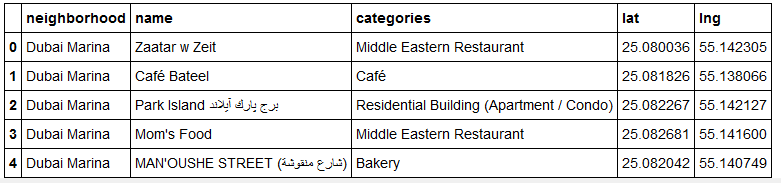

#create a map of the Marina district and highlight nearby venues

In [ ]:
map_marina = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(df_Marina['lat'], df_Marina['lng'], df_Marina['name'], df_Marina['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_marina) 
    
map_marina

In [ ]:
marina_venues['categories'].value_counts()

Hotel                                       9
Coffee Shop                                 7
Middle Eastern Restaurant                   6
Italian Restaurant                          5
Burger Joint                                4
Asian Restaurant                            4
Lounge                                      4
Restaurant                                  3
Yoga Studio                                 3
Spa                                         2
Gym / Fitness Center                        2
Café                                        2
French Restaurant                           2
Clothing Store                              2
Pool                                        2
Shopping Mall                               2
Breakfast Spot                              2
Waterfront                                  1
Speakeasy                                   1
Grocery Store                               1
Bistro                                      1
Modern European Restaurant                  1
Hookah Bar                                  1
Nightclub                                   1
Gym                                         1
Multiplex                                   1
Beach                                       1
Caribbean Restaurant                        1
Eastern European Restaurant                 1
Fast Food Restaurant                        1
Record Shop                                 1
Salon / Barbershop                          1
Trail                                       1
Tea Room                                    1
Steakhouse                                  1
Bakery                                      1
American Restaurant                         1
Residential Building (Apartment / Condo)    1
Chinese Restaurant                          1
Sports Bar                                  1
Russian Restaurant                          1
Bookstore                                   1
Ice Cream Shop                              1
Resort                                      1
Supermarket                                 1
Lebanese Restaurant                         1
Food Truck                                  1
Cosmetics Shop                              1
Tram Station                                1
Sushi Restaurant                            1
Cocktail Bar                                1
Japanese Restaurant                         1
English Restaurant                          1
Mediterranean Restaurant                    1
Name: categories, dtype: int64

#Creation of a similar dataframe for each neighborhood:¶
index # 9 - Al Sufouh

In [ ]:
#define objects for 'Al Soufouh' index [9] in Geo
neighborhood_latitude = Geo.loc[9, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[9, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[9, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_ASufouh = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_ASufouh = df_ASufouh.loc[:, filtered_columns]

# filter the category for each row
df_ASufouh['venue.categories'] = df_ASufouh.apply(get_category_type, axis=1)

# clean columns

df_ASufouh.columns = [col.split(".")[-1] for col in df_ASufouh.columns]
df_ASufouh.insert(0, 'neighborhood', 'Al Sufouh')

print('{} venues were returned by Foursquare.'.format(df_ASufouh.shape[0]))
df_ASufouh.head()

5 venues were returned by Foursquare.  !https://github.com/bettyweb/Coursera_Capstone/blob/master/3.PNG) "List first 5 venues of Al Sufouh"

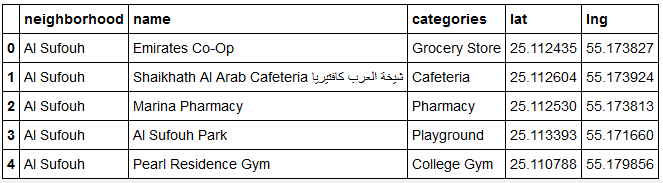

index # 10 DIFC

In [ ]:
#define objects for 'DIFC' index [10] in Geo
neighborhood_latitude = Geo.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[10, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_DIFC = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_DIFC = df_DIFC.loc[:, filtered_columns]

# filter the category for each row
df_DIFC['venue.categories'] = df_DIFC.apply(get_category_type, axis=1)

# clean columns

df_DIFC.columns = [col.split(".")[-1] for col in df_DIFC.columns]
df_DIFC.insert(0, 'neighborhood', 'DIFC')

print('{} venues were returned by Foursquare.'.format(df_DIFC.shape[0]))
df_DIFC.head()

75 venues were returned by Foursquare.  !https://github.com/bettyweb/Coursera_Capstone/blob/master/4.PNG) "List first 5 venues of DIFC"

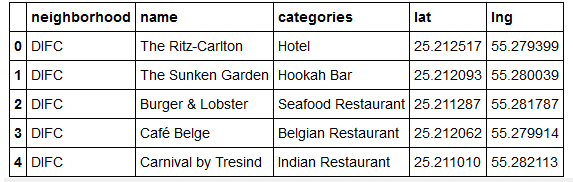

index # 11 Business Bay

In [ ]:
#define objects for 'Business_Bay' index [11] in Geo
neighborhood_latitude = Geo.loc[11, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[11, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[11, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_Business_Bay = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Business_Bay = df_Business_Bay.loc[:, filtered_columns]

# filter the category for each row
df_Business_Bay['venue.categories'] = df_Business_Bay.apply(get_category_type, axis=1)

# clean columns

df_Business_Bay.columns = [col.split(".")[-1] for col in df_Business_Bay.columns]
df_Business_Bay.insert(0, 'neighborhood', 'Business Bay')

print('{} venues were returned by Foursquare.'.format(df_Business_Bay.shape[0]))
df_Business_Bay.head()



22 venues were returned by Foursquare. !https://github.com/bettyweb/Coursera_Capstone/blob/master/5.PNG) "List first 5 venues of Business Bay"

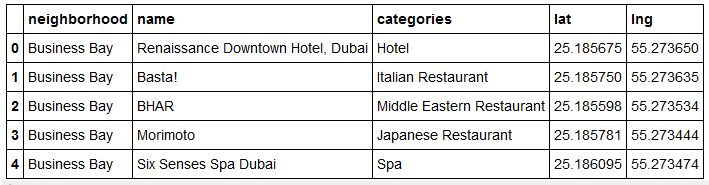

#index # 12 Jumeirah Lakes Towers

In [ ]:
#define objects for 'JLT' index [12] in Geo
neighborhood_latitude = Geo.loc[12, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[12, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[12, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_JLT = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_JLT = df_JLT.loc[:, filtered_columns]

# filter the category for each row
df_JLT['venue.categories'] = df_JLT.apply(get_category_type, axis=1)

# clean columns

df_JLT.columns = [col.split(".")[-1] for col in df_JLT.columns]
df_JLT.insert(0, 'neighborhood', 'Jumeirah Lakes Towers')

print('{} venues were returned by Foursquare.'.format(df_JLT.shape[0]))
df_JLT.head()

33 venues were returned by Foursquare.  !https://github.com/bettyweb/Coursera_Capstone/blob/master/6.PNG) "List  first 5 vemues of Jumeirah Lakes Towers"

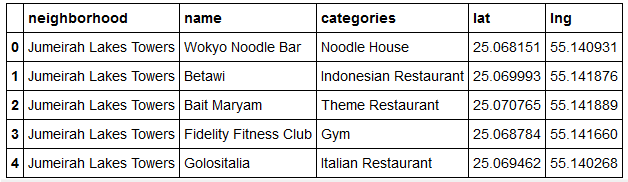

#index 13 Barsha Heights

In [ ]:
#define objects for 'Barsha' index [12] in Geo
neighborhood_latitude = Geo.loc[13, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[13, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[13, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_Barsha = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Barsha = df_Barsha.loc[:, filtered_columns]

# filter the category for each row
df_Barsha['venue.categories'] = df_Barsha.apply(get_category_type, axis=1)

# clean columns

df_Barsha.columns = [col.split(".")[-1] for col in df_Barsha.columns]
df_Barsha.insert(0, 'neighborhood', 'Barsha Heights')

print('{} venues were returned by Foursquare.'.format(df_Barsha.shape[0]))
df_Barsha.head()

62 venues were returned by Foursquare. !https://github.com/bettyweb/Coursera_Capstone/blob/master/7.PNG) "List  first 5 vemues of Barsha Heights"

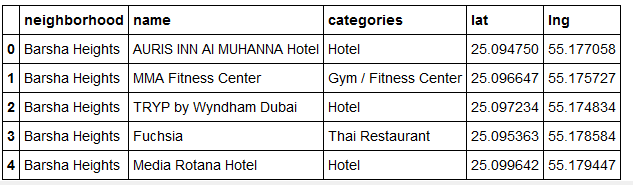

#Analysis of venuw distribution

In [ ]:
df_venues = pd.concat([df_Barsha, df_JLT, df_Business_Bay, df_DIFC, df_Marina, df_ASufouh])
df_venues['count'] = 1
df_venues.shape

(295, 6)

In [ ]:
total_venues = pd.pivot_table(df_venues,index=["neighborhood"], values=["count"],aggfunc=np.sum)
total_venues

!https://github.com/bettyweb/Coursera_Capstone/blob/master/8.PNG) "List of total venues"

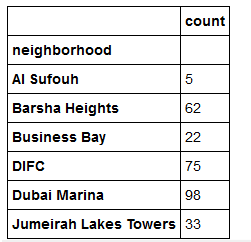

In [ ]:
df_venues2 = df_venues.copy()
df_venues3 = df_venues.copy()
df_venues_rest = df_venues2[df_venues2['categories'].str.contains('Restaurant')].reset_index(drop=True)
df_venues_rest['Venue Type'] = 'Restaurant'
df_venues_hotel = df_venues3[df_venues3['categories'].str.contains('Hotel')].reset_index(drop=True)
df_venues_hotel['Venue Type'] = 'Hotel'
df_venues_final = pd.concat([df_venues_rest,df_venues_hotel]).reset_index(drop=True)
df_venues_final.shape

(133, 7)

In [ ]:
pivot = pd.pivot_table(df_venues_final,index=["neighborhood","Venue Type"], values=["count"],aggfunc=np.sum)
pivot

!https://github.com/bettyweb/Coursera_Capstone/blob/master/9.PNG) "table Neighborhood against venue type"

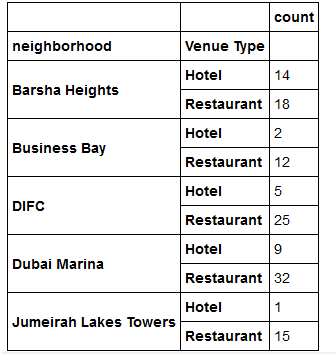

In [ ]:
df_venues_final.groupby('neighborhood')['Venue Type']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True)

<matplotlib.axes._subplots.AxesSubplot at 0x1a1fa501d0> !https://github.com/bettyweb/Coursera_Capstone/blob/master/10.PNG) "bar chart Neighborhood against venue type"

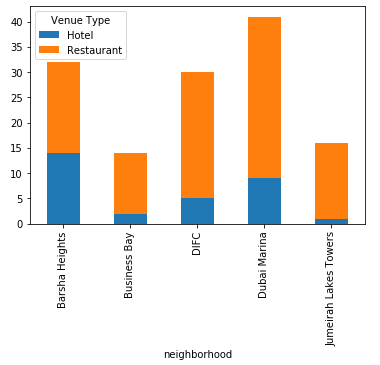

#Create 'one hot' file with dummy values by venue category

In [ ]:
# one hot encoding
dubai_onehot = pd.get_dummies(df_venues_final[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dubai_onehot['neighborhood'] = df_venues_final['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot.head()

!https://github.com/bettyweb/Coursera_Capstone/blob/master/11.PNG) "list restaurant type for Barsha Heights"

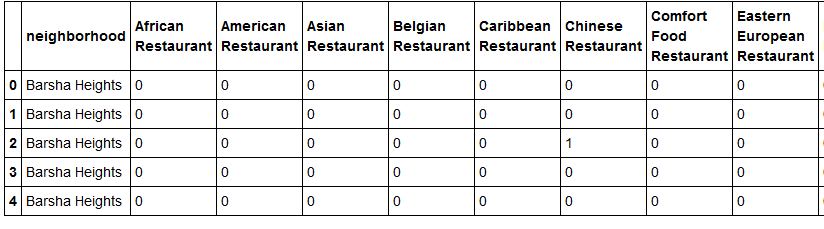

#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category !https://github.com/bettyweb/Coursera_Capstone/blob/master/12.PNG)

In [ ]:
dubai_grouped = dubai_onehot.groupby('neighborhood').mean().reset_index()
dubai_grouped

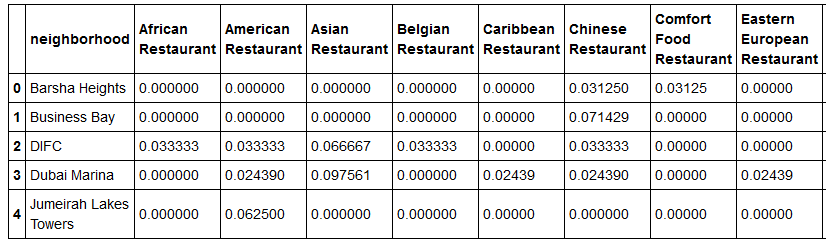

In [ ]:
dubai_grouped.shape

(5, 36)

#print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in dubai_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = dubai_grouped[dubai_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barsha Heights----
                       venue  freq
0                      Hotel  0.41
1  Middle Eastern Restaurant  0.19
2         Italian Restaurant  0.06
3            Thai Restaurant  0.06
4         Mexican Restaurant  0.03


----Business Bay----
                       venue  freq
0                 Restaurant  0.21
1         Italian Restaurant  0.14
2  Middle Eastern Restaurant  0.14
3                      Hotel  0.14
4          German Restaurant  0.07


----DIFC----
                venue  freq
0               Hotel  0.17
1  Italian Restaurant  0.13
2          Restaurant  0.10
3   Indian Restaurant  0.10
4    Asian Restaurant  0.07


----Dubai Marina----
                       venue  freq
0                      Hotel  0.22
1  Middle Eastern Restaurant  0.15
2         Italian Restaurant  0.12
3           Asian Restaurant  0.10
4                 Restaurant  0.07


----Jumeirah Lakes Towers----
                   venue  freq
0     Italian Restaurant  0.19
1  Vietnamese Restaurant  0.12
2             Restaurant  0.06
3      Korean Restaurant  0.06
4       Theme Restaurant  0.06

#write a function to sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = dubai_grouped['neighborhood']

for ind in np.arange(dubai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

print each neighborhood along with the top 5 most common venues  !https://github.com/bettyweb/Coursera_Capstone/blob/master/13.PNG)

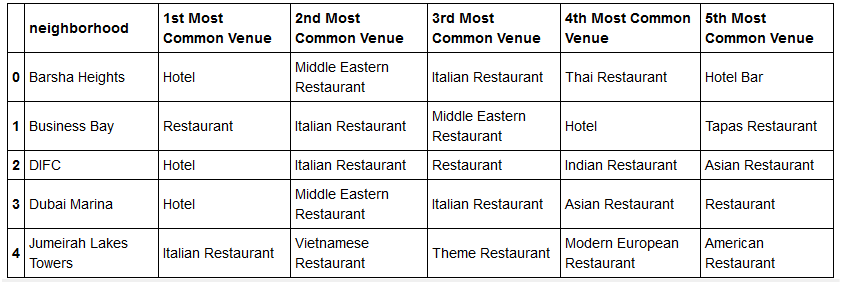

In [ ]:
#define objects for 'DIFC' index [10] in Geo
neighborhood_latitude = Geo.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[10, 'Neighborhood'] # neighborhood name

map_DIFC = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(df_DIFC['lat'], df_DIFC['lng'], df_DIFC['name'], df_DIFC['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_DIFC) 
    
map_DIFC



Map Dubai DIFC  !https://github.com/bettyweb/Coursera_Capstone/blob/master/MapDubaiDIFC.PNG

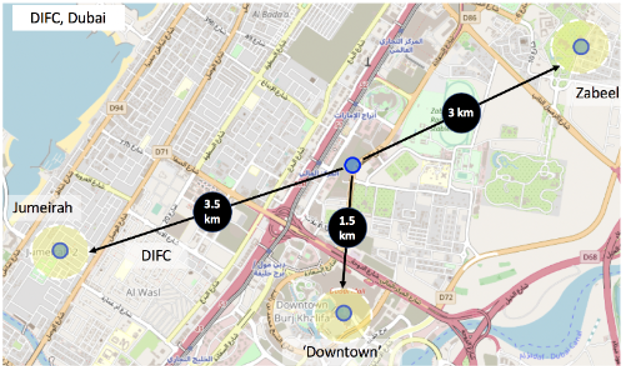